In [10]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import mujoco
from mujoco import mjx
import jax
import pickle
import numpy as np
from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
import utils
import controller as ctrl
import operations as op
from jax import numpy as jnp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

model_xml = "../models/rodent_stac_optimized.xml"
params_path = "../params/params.yaml"
utils.init_params(params_path)

data_path = "../transform_hyb_12_22_1.p"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### set up mj model -- stepping in mjx so we can do batch processing

In [11]:
# Load mjx_model and mjx_data and set marker sites
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
# physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)

rescale.rescale_subtree(
    root,
    utils.params["SCALE_FACTOR"],
    utils.params["SCALE_FACTOR"],
)

# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    offsets = np.array(d['offsets'])

# slice kp_data to match qposes length
kp_data = kp_data[:qposes.shape[0]]

In [12]:
def resid(mjx_model, mjx_data, qpos, kps):
    mjx_data = mjx_data.replace(qpos=qpos)
    # Forward kinematics
    mjx_data = op.kinematics(mjx_model, mjx_data)
    mjx_data = op.com_pos(mjx_model, mjx_data)
    # get marker positions
    markers = op.get_site_xpos(mjx_data).flatten()
    # Return the summed squared error
    return jnp.sum(jnp.square((kps - markers)))

In [13]:
@jax.vmap
def batch_init(batch_qposes):
    mjx_model = mjx.put_model(mj_model)
    mjx_model = op.set_site_pos(mjx_model, jnp.reshape(offsets, (-1, 3))) 
    mjx_data = mjx.make_data(mjx_model)
    return mjx_model, mjx_data

In [16]:
# reshape qposes and kp_data such that it is shape: (n, b, x)
# n = iterations, b = batchsize, x = dims of the data
clip_len = 250
a = qposes.shape[0]//clip_len
batch_qposes = qposes.reshape(a,clip_len,74)
batch_kps = kp_data.reshape(a,clip_len,69)

batch_qposes.shape, batch_kps.shape

((1440, 250, 74), (1440, 250, 69))

In [17]:
mjx_model, mjx_data = batch_init(batch_qposes)
jit_vmap_resid = jax.jit(jax.vmap(resid))

In [18]:
errors = []
# render while stepping using mujoco
for i in range(clip_len):
    if i%50 == 0:
        print(f"{i}")
    qpos = batch_qposes[:, i, :]
    kps = batch_kps[:, i, :]
    # Calculate squared error btwn offsets and keypoints
    errors.append(jit_vmap_resid(mjx_model, mjx_data, qpos, kps))

errors = np.array(errors)
errors = errors.ravel(order="F")
# Save it as .npy file
np.save("../offset_errors/errors_" + data_path[3:-2] + ".npy", errors)

0
50
100
150
200


## Plots below

In [19]:
# errors = np.load("../offset_errors/errors_transform_random_1k_12_21_1.npy")

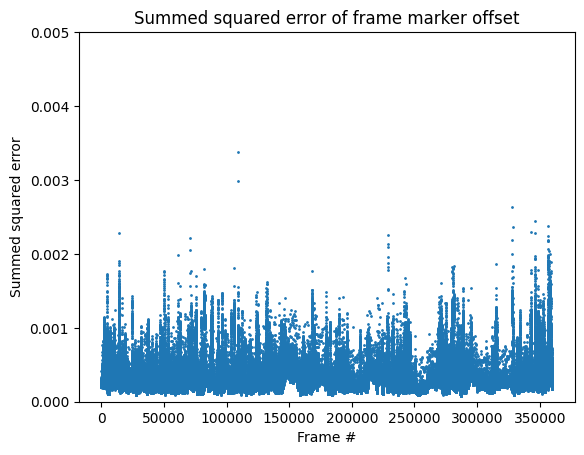

In [21]:
plt.ylim(0, 0.005)
plt.title("Summed squared error of frame marker offset")
plt.xlabel("Frame #")
plt.ylabel("Summed squared error")
x = qposes.shape[0]
plt.scatter(np.arange(x),errors[:x], s=1)

In [11]:
cutoff = x

print(f"mean: {errors[:cutoff].mean()}, std: {errors[:cutoff].std()}")

mean: 0.0003360040136612952, std: 0.00018766766879707575


In [32]:
indices = np.where(errors[:cutoff] > 0.0015)[0]

print(f"there are {indices.shape[0]} not good offset frames before the cutoff at {cutoff}")

there are 245 not good offset frames before the cutoff at 360000


(array([0.0000e+00, 4.1400e+02, 2.0973e+04, 6.0720e+04, 6.2716e+04,
        4.8241e+04, 3.8906e+04, 3.1283e+04, 2.3575e+04, 1.8559e+04,
        1.5157e+04, 1.0895e+04, 6.9330e+03, 4.9860e+03, 3.3170e+03,
        2.9390e+03, 2.1710e+03, 1.6500e+03, 1.2500e+03, 1.0250e+03,
        8.9500e+02, 6.1600e+02, 5.1000e+02, 4.9600e+02, 3.6400e+02,
        2.9900e+02, 3.0200e+02, 2.1400e+02, 2.7400e+02, 7.5000e+01,
        4.4000e+01, 5.0000e+01, 2.0000e+01, 2.0000e+01, 2.3000e+01,
        1.7000e+01, 1.8000e+01, 1.4000e+01, 1.1000e+01, 7.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

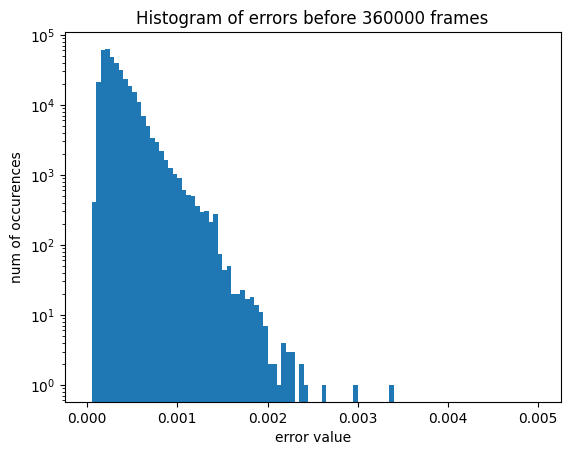

In [14]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(errors[:cutoff], bins=100, range=(0,0.005), log=True)


In [15]:
# Plot a histogram where the values are hte change in qpos from previous to current frame
# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])

qpos_diff = np.diff(qposes, axis=0)

In [16]:
qpos_diff_summed = np.abs(qpos_diff).sum(axis=1)
qpos_diff_summed.shape

(359999,)

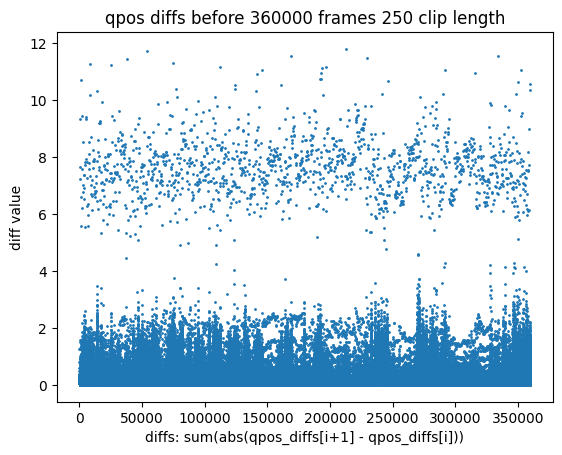

In [17]:
plt.title(f"qpos diffs before {cutoff} frames {clip_len} clip length")
plt.xlabel("diffs: sum(abs(qpos_diffs[i+1] - qpos_diffs[i]))")
plt.ylabel("diff value")
plt.scatter(np.arange(cutoff-1), qpos_diff_summed[:cutoff], s=1)

In [19]:
# Split qpos_diff_summed into two arrays: one has 10 values for every multiple of 360, 
# and the other one has the rest of the values
# This is to see if the diffs statistics are different between the two
mask = np.array([(i+1)%clip_len <= 5 for i in range(cutoff-1)])
qpos_diff_summed_start = qpos_diff_summed[:cutoff][mask]
qpos_diff_summed_start.shape

(8639,)

(array([2.150e+02, 9.940e+02, 1.840e+03, 1.335e+03, 8.940e+02, 6.580e+02,
        5.320e+02, 3.540e+02, 2.190e+02, 1.320e+02, 1.700e+01, 4.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 6.000e+00, 8.000e+00, 1.000e+01, 2.600e+01,
        4.500e+01, 7.500e+01, 8.500e+01, 1.010e+02, 1.510e+02, 1.490e+02,
        1.380e+02, 1.580e+02, 1.380e+02, 9.600e+01, 6.700e+01, 4.500e+01,
        3.700e+01, 2.800e+01, 1.900e+01, 1.400e+01, 8.000e+00, 5.000e+00,
        8.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

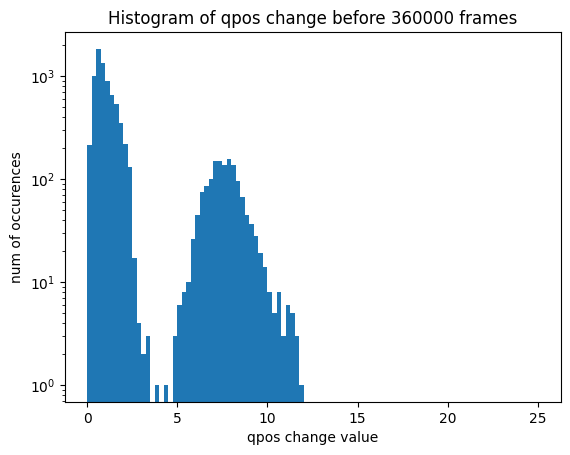

In [20]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of qpos change before {cutoff} frames")
plt.xlabel("qpos change value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_start, bins=100, range=(0,25), log=True)

(351360,)


(array([2.70159e+05, 5.00050e+04, 1.63610e+04, 7.16600e+03, 3.44300e+03,
        1.86900e+03, 1.04300e+03, 5.86000e+02, 3.14000e+02, 1.78000e+02,
        1.05000e+02, 5.40000e+01, 2.50000e+01, 1.80000e+01, 1.00000e+01,
        1.00000e+00, 9.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

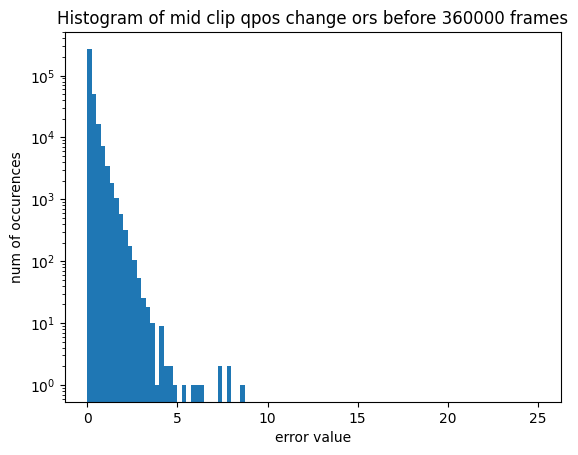

In [21]:
mask = np.array([(i+1)%clip_len > 5 for i in range(cutoff-1)])
qpos_diff_summed_mid = qpos_diff_summed[:cutoff][mask]
print(qpos_diff_summed_mid.shape)
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of mid clip qpos change ors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_mid, bins=100, range=(0,25), log=True)

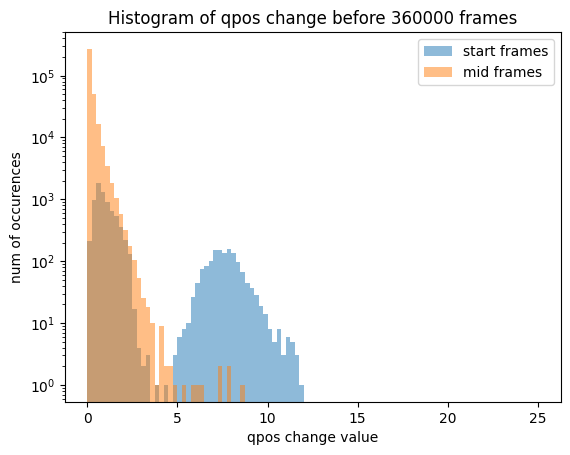

In [22]:
# Overlay the above two histograms 
plt.title(f"Histogram of qpos change before {cutoff} frames")
plt.xlabel("qpos change value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_start, bins=100, range=(0,25), log=True, alpha=0.5, label="start frames")
plt.hist(qpos_diff_summed_mid, bins=100, range=(0,25), log=True, alpha=0.5, label="mid frames")
plt.legend()


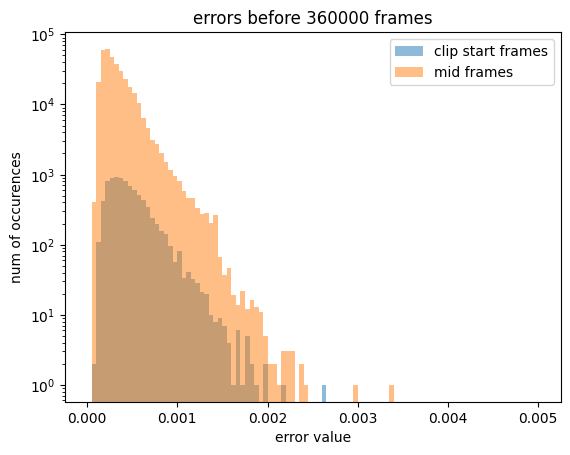

In [25]:
mask = np.array([(i+1)%clip_len > 5 for i in range(cutoff)])
errors_mid = errors[:cutoff][mask]
mask = np.array([(i+1)%clip_len <= 5 for i in range(cutoff)])
errors_start = errors[:cutoff][mask]
plt.title(f"errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(errors_start, bins=100, range=(0, 0.005), log=True, alpha=0.5, label="clip start frames")
plt.hist(errors_mid, bins=100, range=(0, 0.005), log=True, alpha=0.5, label="mid frames")
plt.legend()


# view select frame where we have high error

In [33]:
indices[:100]

array([  4830,   4831,   4832,   4833,   4834,   4835,   4836,   4837,
        13762,  13776,  13927,  13928,  13961,  13962,  14040,  14041,
        14042,  14053,  14054,  14055,  14056,  14057,  14058,  14059,
        14075,  14076,  14077,  14078,  14079,  14080,  14081,  14082,
        49773,  49774,  49775,  49776,  49777,  49778,  49779,  49780,
        49781,  49782,  61000,  61001,  62829,  70738,  70739,  70740,
        70741,  71750,  75250,  75844,  82161,  82162,  82163,  82250,
        82251,  82478,  82479, 106000, 106250, 109408, 109409, 109413,
       131740, 131875, 131876, 131922, 131923, 168199, 168250, 168251,
       168252, 229072, 229073, 229074, 229075, 229076, 229077, 229078,
       229079, 229080, 242500, 243215, 270902, 279750, 279791, 279792,
       279793, 281153, 281154, 281156, 281157, 281158, 281159, 281160,
       281161, 281162, 281163, 281164])

In [35]:
import mediapy as media
from dm_control.mujoco.wrapper.mjbindings import enums
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)
renderer = mujoco.Renderer(mj_model)
mj_data = mujoco.MjData(mj_model)
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = 1
scene_option.sitegroup[2] = 1

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False

""

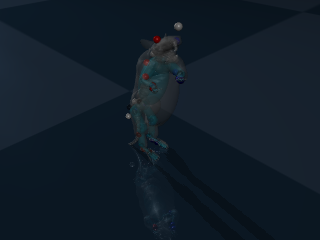

In [36]:
index = 4830
mj_data.qpos = qposes[index]
physics, mj_model = ctrl.set_keypoint_sites(physics, keypoint_sites, kp_data[index])
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, camera="close_profile", scene_option=scene_option)

media.show_image(renderer.render())